In [1]:
import warnings
import numpy as np
import pandas as pd
from pyod.models.mad import MAD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

pd.set_option('max.rows', 250)
warnings.filterwarnings('ignore')

C:\Users\Mnesoma\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
Data = pd.read_csv('Pressure_with_Anomaly_2.csv')

In [3]:
Data['timestamp'] = pd.to_datetime(Data["timestamp"])

In [48]:
def fit_model(model, Data, column='value'):
    
    df = Data.copy()
    data_to_predict = Data[column].to_numpy().reshape(-1, 1)
    predictions = model.fit_predict(data_to_predict)
    df['Predictions'] = predictions
    
    return df

def plot_anomalies(df, x='timestamp', y='value'):

    # categories will be having values from 0 to n
    # for each values in 0 to n it is mapped in colormap
    categories = df['Predictions'].to_numpy()
    colormap = np.array(['g', 'r'])

    f = plt.figure(figsize=(12, 6))
    f = plt.scatter(df[x], df[y], c=colormap[categories])
    f = plt.xlabel(x)
    f = plt.ylabel(y)
    f = plt.xticks(rotation=90)
    plt.show()

# Inter Quartile Range

In [7]:
def find_anomalies(value, lower_threshold, upper_threshold):
    
    if value < lower_threshold or value > upper_threshold:
        return 1
    else: return 0

def iqr_anomaly_detector(Data, column='value', threshold=1.1):
    
    df = Data.copy()
    quartiles = dict(Data[column].quantile([.25, .50, .75]))
    quartile_3, quartile_1 = quartiles[0.75], quartiles[0.25]
    iqr = quartile_3 - quartile_1

    lower_threshold = quartile_1 - (threshold * iqr)
    upper_threshold = quartile_3 + (threshold * iqr)

    print(f"Lower threshold: {lower_threshold}, \nUpper threshold: {upper_threshold}\n")
    
    df['Predictions'] = Data[column].apply(find_anomalies, args=(lower_threshold, upper_threshold))
    return df

Lower threshold: 17.701954000000004, 
Upper threshold: 19.560705999999996



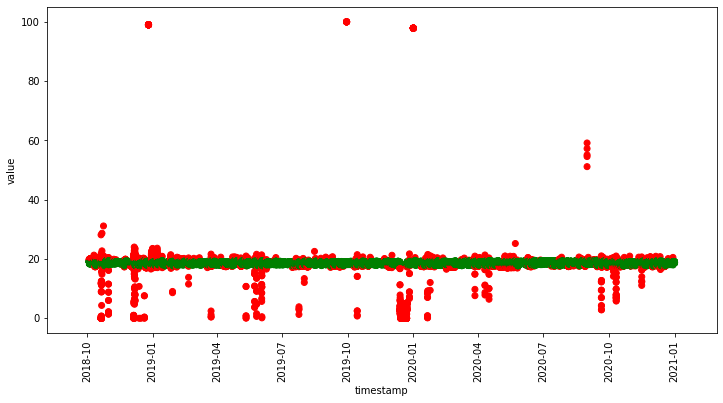

In [49]:
iqr_df = iqr_anomaly_detector(Data)
plot_anomalies(iqr_df)

# Isolation Forest

In [13]:
def scale_anomaly_scores(s):
    """Changing (-0.5, 0.5) to (0, 1)"""
    a, b = (-0.5, 0.5), (1, 0)
    (a1, a2), (b1, b2) = a, b
    return (b1 + ((s - a1) * (b2 - b1) / (a2 - a1))) * 100

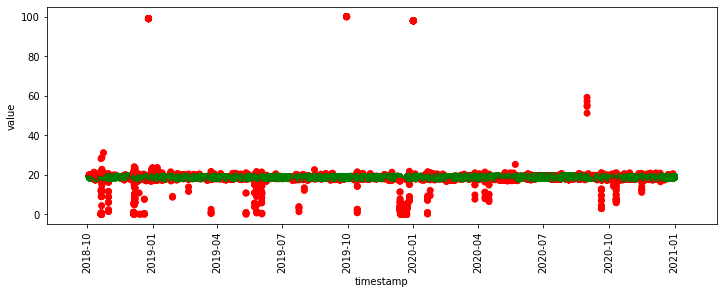

In [47]:
iso_forest = IsolationForest(n_estimators=125)
iso_df = fit_model(iso_forest, Data)
iso_df['Predictions'] = iso_df['Predictions'].map(lambda x: 1 if x==-1 else 0)
plot_anomalies(iso_df)

In [15]:
iso_df.head()

,timestamp,value,Predictions
0,2018-10-04 00:00:00,19.19495,0
1,2018-10-04 00:27:00,19.04453,0
2,2018-10-04 00:28:00,19.26260,0
3,2018-10-04 00:37:00,19.05637,0
4,2018-10-04 00:46:00,19.25317,0


In [16]:
univariate_data = Data['value'].to_numpy().reshape(-1, 1)
# These values range from -0.5 to 0.5
anomaly_scores = iso_forest.decision_function(univariate_data)
anomaly_scores

array([0.04886386, 0.10295042, 0.00900373, ..., 0.10285085, 0.11731228,
       0.11731228])

In [29]:
iso_df['Anomaly Scores'] = anomaly_scores
iso_df.head()

,timestamp,value,Predictions,Anomaly Scores
0,2018-10-04 00:00:00,19.19495,0,0.048864
1,2018-10-04 00:27:00,19.04453,0,0.102950
2,2018-10-04 00:28:00,19.26260,0,0.009004
3,2018-10-04 00:37:00,19.05637,0,0.093530
4,2018-10-04 00:46:00,19.25317,0,0.019190


# KNN model

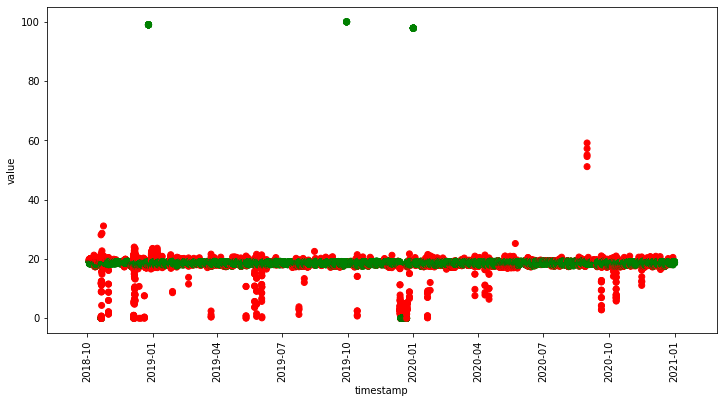

In [50]:
"""KNN Based Outlier Detection"""
knn_model = KNN()
knn_df = fit_model(knn_model, Data)
plot_anomalies(knn_df)

In [32]:
def get_anomaly_scores(model):
  anomaly_scores = model.decision_scores_
  threshold = model.threshold_
  return anomaly_scores, threshold

In [33]:
anomaly_scores, threshold = get_anomaly_scores(knn_model)
print(f"Anomaly Scores: {anomaly_scores}, \nThreshold: {threshold}")

Anomaly Scores: [8.0e-05 2.0e-05 1.3e-04 ... 5.0e-05 3.0e-05 3.0e-05], 
Threshold: 0.0002099999999991553


In [34]:
knn_df['Anomaly Scores'] = anomaly_scores
knn_df.head()

,timestamp,value,Predictions,Anomaly Scores
0,2018-10-04 00:00:00,19.19495,0,0.00008
1,2018-10-04 00:27:00,19.04453,0,0.00002
2,2018-10-04 00:28:00,19.26260,0,0.00013
3,2018-10-04 00:37:00,19.05637,0,0.00006
4,2018-10-04 00:46:00,19.25317,0,0.00013


In [35]:
# Threshold computation
pd.Series(anomaly_scores).quantile(.90)

0.0002099999999991553

# Local Outlier Factor Model

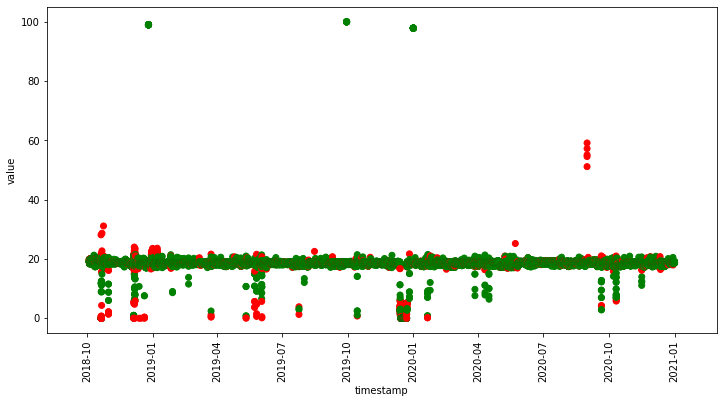

In [51]:
lof_model = LOF()
lof_df = fit_model(lof_model, Data)
plot_anomalies(lof_df)

In [37]:
anomaly_scores, threshold = get_anomaly_scores(lof_model)
print(f"Anomaly Scores: {anomaly_scores}, \nThreshold: {threshold}")

Anomaly Scores: [1.00666953 1.04217189 0.9899425  ... 0.98774249 0.97775098 0.97775098], 
Threshold: 1.0797704251094205


In [38]:
# Threshold computation
pd.Series(anomaly_scores).quantile(.90)

1.0797704251094205